In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
#extract csv from bag files
def data_csv(b):

    csvfiles = []
    for t in b.topics:
        data = b.message_by_topic(t)
        csvfiles.append(data)

    print(csvfiles[0])
    data = pd.read_csv(csvfiles[0])
    return data

In [3]:
b = bagreader("/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving.bag")
csv_data = data_csv(b)

[INFO]  Data folder /home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving already exists. Not creating.
/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving/gps.csv


In [4]:
df_gps = pd.read_csv("/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving/gps.csv")

In [5]:
df_imu = pd.read_csv("/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving/imu.csv")

In [6]:
#To transform back matrix - use the calibrated matrix
# matrix = [[ 0.87435829, -0.02553677],
#        [-0.02553677,  0.99480963]]
matrix = [[ 0.8760, -0.0243],
       [-0.0243,  0.9952]]
matrix

[[0.876, -0.0243], [-0.0243, 0.9952]]

In [7]:
offset_x, offset_y = ( -0.1604, -0.011510)

In [8]:
mag_x = df_imu['MagField.magnetic_field.x']
mag_y = df_imu['MagField.magnetic_field.y']

In [9]:
#correct the offset first
corrected_x = mag_x - offset_x
corrected_y = mag_y - offset_y

In [10]:
corrected_coords = []
for i,j in zip(corrected_x, corrected_y):
    corrected_coords.append(matrix * np.matrix([i,j]).transpose())
# corrected_coords

In [11]:
corrected_coords = np.squeeze(np.asarray(corrected_coords))
correct_x = []
correct_y = []
for a in corrected_coords:
    correct_x.append(a[0])
    correct_y.append(a[1])


In [12]:
df_imu['MagField_x'] = correct_x
df_imu['MagField_y'] = correct_y

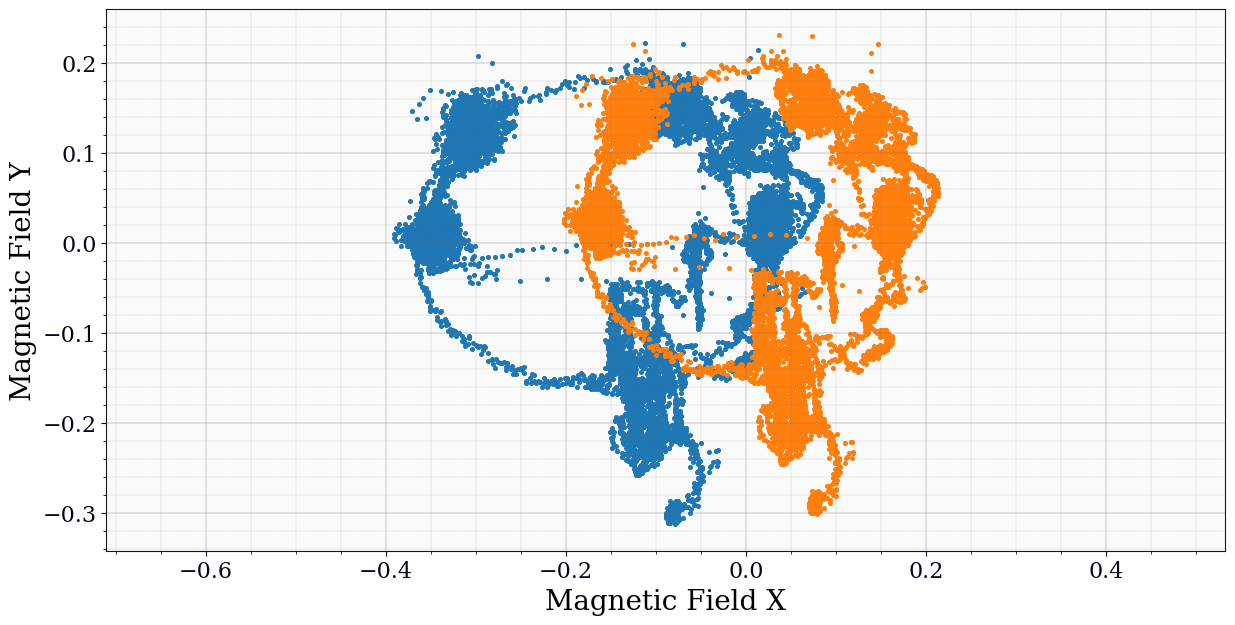

In [13]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].axis('equal')
ax[0].scatter(x='MagField.magnetic_field.x', y='MagField.magnetic_field.y', data=df_imu, s=7)
ax[0].scatter(x='MagField_x', y='MagField_y', data=df_imu, s=7)
plt.xlabel("Magnetic Field X")
plt.ylabel("Magnetic Field Y")
plt.show()


In [14]:
from math import  fmod 
def normalize_angle_positive(angle):
    """
    Wrap the angle between 0 and 2 * pi.

    Args:
        angle (float): angle to wrap.

    Returns:
         The wrapped angle.

    """
    pi_2 = 2. * np.pi

    return fmod(fmod(angle, pi_2) + pi_2, pi_2)


def wraptopi_pi(angle):
    """
    Wrap the angle between -pi and pi.

    Args:
        angle (float): angle to wrap.

    Returns:
         The wrapped angle.

    """
    a = normalize_angle_positive(angle)
    if a > np.pi:
        a -= 2. * np.pi

    return a

In [15]:
wraptopi_pi(3*np.pi)

3.141592653589793

In [16]:
#integrate yaw rate - gyro
yaw_rate = df_imu['IMU.angular_velocity.z']

In [17]:
df_imu['time_seconds'] =  df_imu['Header.stamp.secs'] + df_imu['Header.stamp.nsecs']/(10**9)
df_imu['time_seconds_plot'] =  df_imu['time_seconds'] - df_imu['time_seconds'].min(axis=0)
df_imu['time_seconds_plot'] 

0          0.000000
1          0.024930
2          0.049936
3          0.074992
4          0.100404
            ...    
26346    658.650072
26347    658.675356
26348    658.699905
26349    658.724939
26350    658.750218
Name: time_seconds_plot, Length: 26351, dtype: float64

In [18]:
from scipy import integrate
y = yaw_rate
x = df_imu['time_seconds_plot']
yaw = integrate.cumtrapz( y, x, initial=x[0])
# yaw = np.unwrap(yaw)
# print(yaw[0])
yaw_values = []
for y in yaw:
    yaw_values.append(wraptopi_pi(y))
df_imu['gyro_yaw'] = yaw_values
df_imu['gyro_yaw']

0        0.000000
1        0.000049
2        0.000091
3        0.000125
4        0.000164
           ...   
26346    0.496579
26347    0.496647
26348    0.496713
26349    0.496786
26350    0.496867
Name: gyro_yaw, Length: 26351, dtype: float64

In [19]:
normalize_yaw = []
for y in yaw:
    cos_y = np.cos(y)
    y_t = np.arccos(cos_y)
    normalize_yaw.append(y_t)
max(normalize_yaw), min(normalize_yaw) 
df_imu['gyro_yaw'] = normalize_yaw


In [20]:
# df_imu['mag_yaw']=(np.arctan2(df_imu['MagField_x'] / np.sqrt(df_imu['MagField_x']**2 + df_imu['MagField_y']**2 )))
df_imu['mag_yaw']=(np.arctan2(-df_imu['MagField_y'], df_imu['MagField_x'])) 

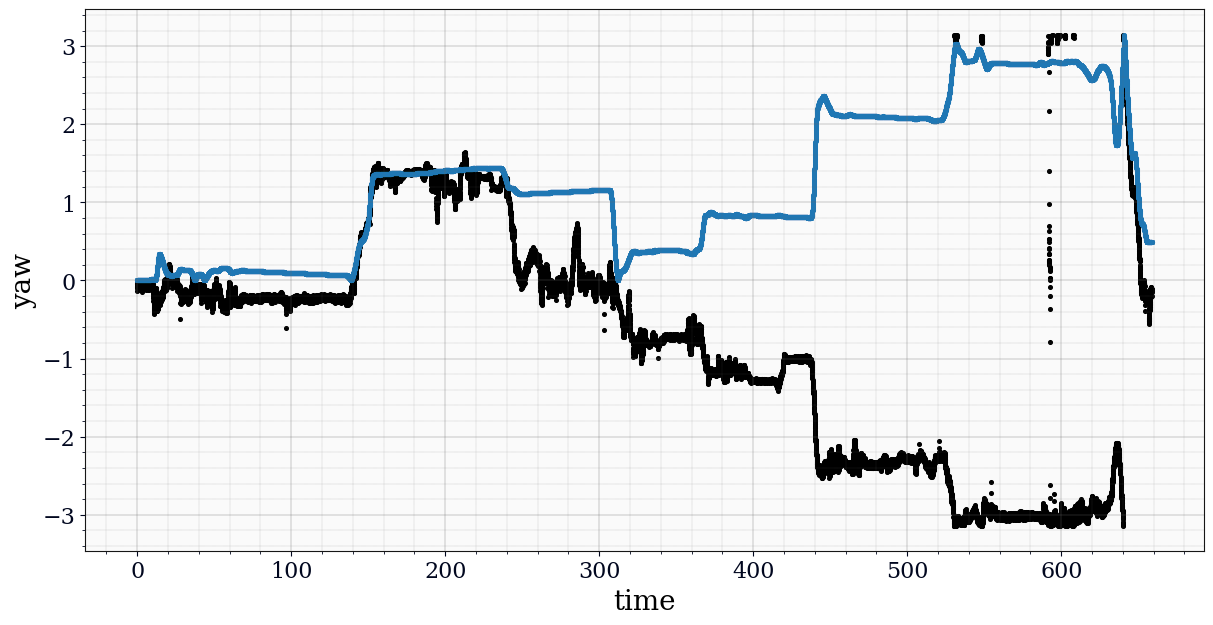

In [21]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=df_imu['mag_yaw'], c = 'black', s=7)
ax[0].scatter(x=df_imu['time_seconds_plot'], y= df_imu['gyro_yaw'], s=7)
plt.ylabel("yaw")
plt.xlabel("time")
# plt.savefig('/home/marley/northing.png')
plt.show()

In [22]:
mag_y = df_imu['MagField_y']
mag_y


0        0.012675
1        0.016678
2        0.007801
3        0.014666
4        0.005811
           ...   
26346    0.033536
26347    0.023518
26348    0.018620
26349    0.019637
26350    0.024489
Name: MagField_y, Length: 26351, dtype: float64

In [23]:
#LPF 
import scipy

lowpass = 0.05
a_filtered = df_imu['MagField_y']
# a_filtered = filtfilt(*butter(6, 0.01, btype='high'),a_filtered )

b, a = scipy.signal.butter(3, 0.5, 'lowpass')
filteredLowPass = scipy.signal.filtfilt(b, a, a_filtered)

In [24]:
mag_y = df_imu['MagField_y']
low_mag_y = []
low = mag_y[0]
low_mag_y.append(low)
alpha = 0.5
for mag in mag_y[1:]:
    low = (1-alpha)*mag + alpha*low
    low_mag_y.append(low)


df_imu['MagField_low_y'] = low_mag_y
# low
low_mag_y[0:2], df_imu['MagField_y'][0:2]

([0.012675302, 0.014676637000000001],
 0    0.012675
 1    0.016678
 Name: MagField_y, dtype: float64)

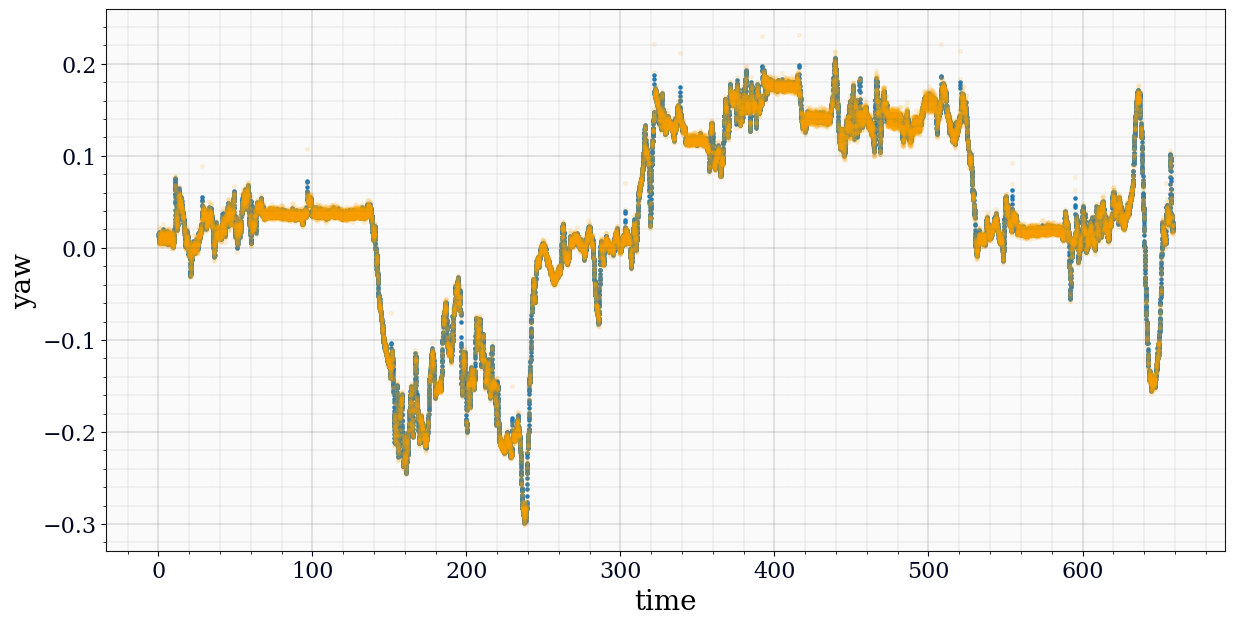

In [25]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x=df_imu['time_seconds_plot'], y= df_imu['MagField_low_y'] , s=5)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=df_imu['MagField_y'], c = 'orange', s=7, alpha = 0.1)
# ax[0].scatter(x=mag_corrected_x, y=mag_corrected_y, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()

In [26]:
def complementary_filter():
    N = len(t)
    dt = np.diff(t)
    g_ref = np.array(g_ref)
    q = np.ones(N, dtype=quaternion)

    # get high-passed angular velocity
    w = filtfilt(*butter(5, highpass, btype='high'), w, axis=0)
    w[np.linalg.norm(w, axis=1) < theta_min] = 0
    q_delta = from_rotation_vector(w[1:] * dt[:, None])

    # get low-passed linear acceleration
    a = filtfilt(*butter(5, lowpass, btype='low'), a, axis=0)

    for i in range(1, N):

        # get rotation estimate from gyroscope
        q_w = q[i - 1] * q_delta[i - 1]

        # get rotation estimate from accelerometer
        v_world = rotate_vectors(q_w, a[i])
        n = np.cross(v_world, g_ref)
        phi = np.arccos(np.dot(v_world / np.linalg.norm(v_world), g_ref))
        q_a = from_rotation_vector(
            (1 - alpha) * phi * n[None, :] / np.linalg.norm(n))[0]

        # fuse both estimates
        q[i] = q_a * q_w

    return q

In [27]:
from scipy.signal import filtfilt, butter

In [51]:
#yaw rate
highpass=0.01
w = df_imu['gyro_yaw']


min(w), max(w)

(0.0, 3.139753878854261)

In [52]:

w = filtfilt(*butter(5, highpass, btype='high'), w, axis=0)

min(w), max(w)

(-0.08009295478852108, 0.18380635191819591)

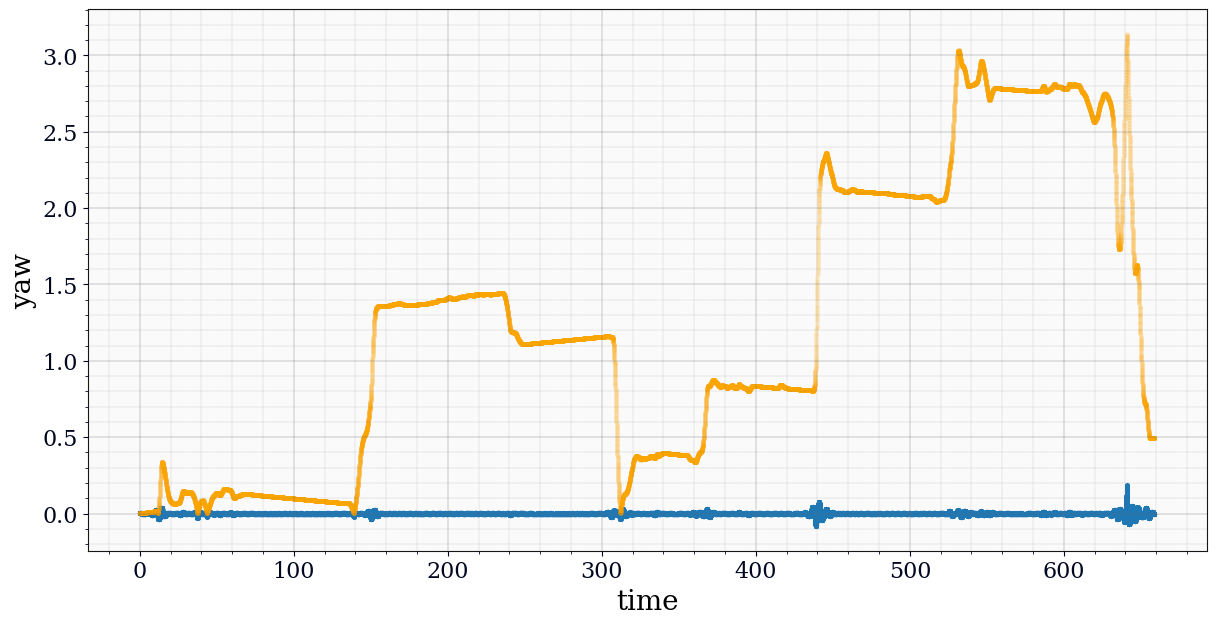

In [53]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x=df_imu['time_seconds_plot'], y= w, s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=df_imu['gyro_yaw'], c = 'orange', s=7, alpha = 0.1)
# ax[0].scatter(x=mag_corrected_x, y=mag_corrected_y, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()

In [31]:
w = df_imu['IMU.angular_velocity.x'], df_imu['IMU.angular_velocity.y'],df_imu['IMU.angular_velocity.z']
a = df_imu['MagField_x'], df_imu['MagField_y'], df_imu['MagField.magnetic_field.z']

In [32]:
w = []
for i,j,k in zip(df_imu['IMU.angular_velocity.x'], df_imu['IMU.angular_velocity.y'],df_imu['IMU.angular_velocity.z']):
    
    w.append((i,j,k))
a = []
for i,j,k in zip(df_imu['MagField_x'], df_imu['MagField_y'], df_imu['MagField.magnetic_field.z']):
    
    a.append((i,j,k))
     
a

[(0.170832507, 0.012675302, 0.1024),
 (0.169946907, 0.016677972000000003, 0.0999),
 (0.170863977, 0.007801252, 0.0954),
 (0.17078390699999998, 0.014665702, 0.0953),
 (0.17091257699999998, 0.005810852, 0.0966),
 (0.170888277, 0.006806052, 0.0954),
 (0.169119507, 0.014711871999999997, 0.0975),
 (0.17234636699999997, 0.022379662, 0.0965),
 (0.17255510699999999, 0.0066603619999999995, 0.0955),
 (0.171550437, 0.015539511999999998, 0.0953),
 (0.17240213699999998, 0.016510412, 0.0965),
 (0.17087867699999998, 0.010784422, 0.1047),
 (0.170863977, 0.007801252, 0.0989),
 (0.172579407, 0.005665162, 0.1025),
 (0.17007557699999998, 0.007823122, 0.1035),
 (0.172516107, 0.004672391999999999, 0.0955),
 (0.169199577, 0.007847422, 0.0917),
 (0.170863977, 0.007801252, 0.1001),
 (0.170002677, 0.010808722, 0.1035),
 (0.169189977, 0.011825791999999998, 0.1046),
 (0.171749577, 0.0037985820000000004, 0.1025),
 (0.17172527699999998, 0.004793782, 0.1013),
 (0.170808207, 0.013670502000000001, 0.1035),
 (0.1715723

In [33]:
import numpy as np
from scipy.signal import filtfilt, butter
from quaternion import quaternion, from_rotation_vector, rotate_vectors

t = df_imu['time_seconds_plot']
N = len(t)
dt = np.diff(t)
g_ref = (0,0,1)
g_ref = np.array(g_ref)
q = np.ones(N, dtype=quaternion)

highpass = 0.01
lowpass = 0.05
theta_min = 1e-6
alpha = 0.4

# get high-passed angular velocity
w = filtfilt(*butter(5, highpass, btype='high'), w, axis=0)
w[np.linalg.norm(w, axis=1) < theta_min] = 0
q_delta = from_rotation_vector(w[1:] * dt[:, None])

# get low-passed linear acceleration
a = filtfilt(*butter(5, lowpass, btype='low'), a, axis=0)

for i in range(1, N):

    # get rotation estimate from gyroscope
    q_w = q[i - 1] * q_delta[i - 1]

    # get rotation estimate from accelerometer
    v_world = rotate_vectors(q_w, a[i])
    n = np.cross(v_world, g_ref)
    phi = np.arccos(np.dot(v_world / np.linalg.norm(v_world), g_ref))
    q_a = from_rotation_vector(
        (1 - alpha) * phi * n[None, :] / np.linalg.norm(n))[0]

    # fuse both estimates
    q[i] = q_a * q_w



In [34]:
q

array([quaternion(1, 0, 0, 0),
       quaternion(0.952398113736375, 0.0220192837418832, -0.304060821996676, -2.49317947763371e-05),
       quaternion(0.90721575433802, 0.0300224730323498, -0.41959291908971, 9.18895844952139e-05),
       ...,
       quaternion(0.154179918131421, -0.430305629944628, -0.135995996767779, -0.878960014190653),
       quaternion(0.15420368112499, -0.430231263176053, -0.135849740234449, -0.879014865057254),
       quaternion(0.154255806161413, -0.430145510569763, -0.135758155008358, -0.879061834770938)],
      dtype=quaternion)

In [35]:
def quaternion_to_euler_angle_vectorized2(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)

    t2 = np.clip(t2, a_min=-1.0, a_max=1.0)
    Y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.arctan2(t3, t4)

    return X, Y, Z

In [36]:
q[1].x

0.02201928374188323

In [37]:
euler_values = []
for quat in q:
    X,Y,Z = quaternion_to_euler_angle_vectorized2(quat.w, quat.x, quat.y, quat.z)
    euler_values.append((X,Y,Z))

In [38]:
yaw_fused = []
for value in euler_values:
    yaw_fused.append(value[2])
    

In [39]:
yaw_fused

[0.0,
 -0.01648481675166448,
 -0.038610748300378216,
 -0.05261538650284607,
 -0.05869885275422067,
 -0.06041812069971242,
 -0.060149201519262493,
 -0.05907844727462841,
 -0.057707982942146616,
 -0.05625984225550514,
 -0.05484464257092677,
 -0.05356101513894428,
 -0.05230174822760765,
 -0.051273927957989775,
 -0.050321367513305536,
 -0.04953759222408334,
 -0.048856938726854815,
 -0.04838170262155162,
 -0.04807116775388499,
 -0.04787886054338755,
 -0.04782572064115108,
 -0.047902713567037764,
 -0.04805743808948439,
 -0.04838286228365532,
 -0.048826032755168315,
 -0.04920895972387844,
 -0.04976625782775903,
 -0.050325687899523484,
 -0.05096539301567073,
 -0.05160020900554724,
 -0.052229769719840294,
 -0.05288481122027576,
 -0.05354712779331539,
 -0.05410392647408646,
 -0.05468705804341939,
 -0.05516767652880318,
 -0.05565096811489619,
 -0.05601608546733784,
 -0.0564000126233049,
 -0.05672096653392392,
 -0.05698515342593946,
 -0.057269836057298504,
 -0.0575285283060597,
 -0.057665447746186

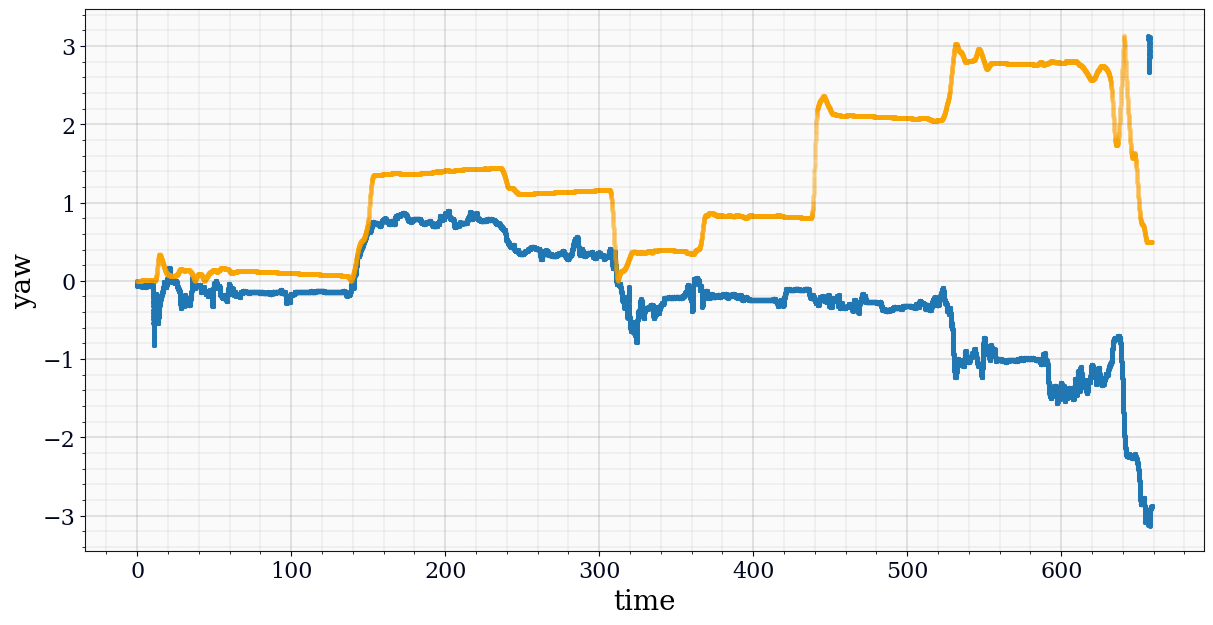

In [40]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x=df_imu['time_seconds_plot'], y=yaw_fused , s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=df_imu['gyro_yaw'], c = 'orange', s=7, alpha = 0.1)
# ax[0].scatter(x=mag_corrected_x, y=mag_corrected_y, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()

In [41]:
orientation = []
for x,y,z,w in zip(df_imu['IMU.orientation.x'], df_imu['IMU.orientation.y'],df_imu['IMU.orientation.z'],df_imu['IMU.orientation.w'] ):
    
    orientation.append((w,x,y,z))


In [42]:
orientation[3][3]

-0.0799743070589018

In [43]:
orientation_values = []
for o in orientation:
    X,Y,Z = quaternion_to_euler_angle_vectorized2(o[0],o[1], o[2], o[3])
    orientation_values.append((X,Y,Z))

In [44]:
yaw_orientation_fused = []
for value in orientation_values:
    yaw_orientation_fused.append(value[2])
    

In [45]:
yaw_orientation_fused

[-0.15926129424448235,
 -0.1591740277818827,
 -0.15910421461180307,
 -0.1590867613192829,
 -0.15905185473424327,
 -0.15901694814920336,
 -0.15899949485668338,
 -0.15898204156416343,
 -0.1589820415641634,
 -0.15894713497912338,
 -0.15892968168660362,
 -0.15887732180904368,
 -0.1588424152240038,
 -0.15879005534644408,
 -0.15873769546888422,
 -0.15870278888384437,
 -0.1587027888838443,
 -0.15863297571376445,
 -0.1585631625436848,
 -0.1585457092511649,
 -0.1585282559586449,
 -0.15851080266612488,
 -0.15844098949604501,
 -0.1584235362035252,
 -0.15840608291100533,
 -0.15838862961848527,
 -0.15833626974092546,
 -0.15828390986336574,
 -0.15821409669328584,
 -0.1581617368157261,
 -0.15812683023068622,
 -0.15805701706060626,
 -0.1580395637680864,
 -0.1580221104755665,
 -0.1580046571830466,
 -0.1579697505980066,
 -0.15789993742792702,
 -0.15786503084288703,
 -0.157865030842887,
 -0.1578301242578472,
 -0.15779521767280727,
 -0.1577603110877674,
 -0.1577603110877672,
 -0.15774285779524747,
 -0.157

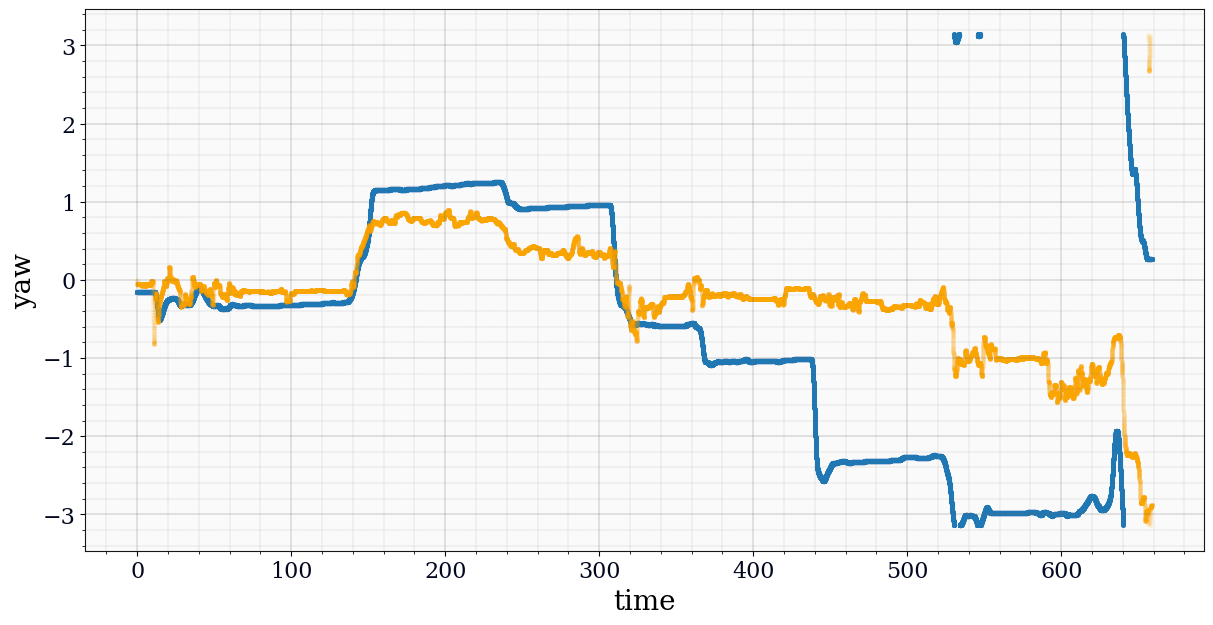

In [46]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x=df_imu['time_seconds_plot'], y=yaw_orientation_fused , s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=yaw_fused, c = 'orange', s=7, alpha = 0.1)
# ax[0].scatter(x=mag_corrected_x, y=mag_corrected_y, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()

In [47]:
normalize_yaw = []
for y in yaw_orientation_fused:
    sin_y = np.sin(y)
    y_t = np.arcsin(sin_y)
    normalize_yaw.append(y_t)
max(normalize_yaw), min(normalize_yaw) 

(1.5676896407263534, -1.5697840358286952)

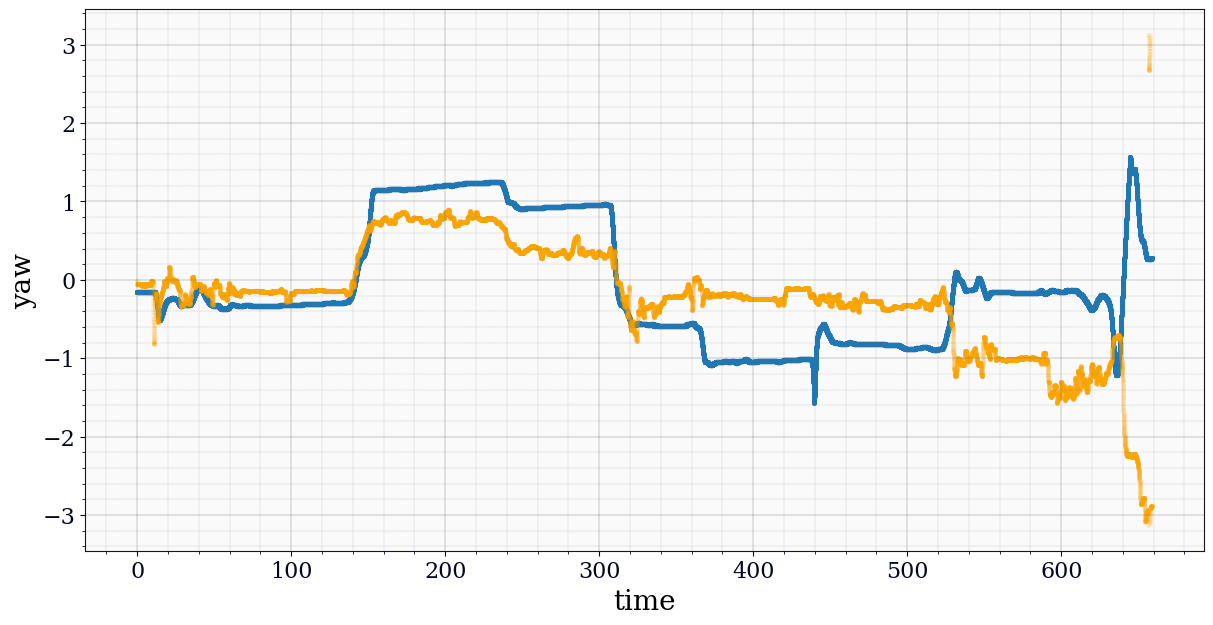

In [48]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x=df_imu['time_seconds_plot'], y=normalize_yaw , s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=yaw_fused, c = 'orange', s=7, alpha = 0.1)
# ax[0].scatter(x=mag_corrected_x, y=mag_corrected_y, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()